In [1]:

# basic packages
import pandas as pd
import numpy as np
import datetime as dt
from pytz import timezone
import urllib
import os
import math
from scipy import stats
from scipy.signal import find_peaks, spectrogram

# packages for visualizations
import matplotlib.dates as mdates
import seaborn as sns

from prophet import Prophet
from prophet.plot import plot_seasonality , plot_weekly, plot_yearly

from matplotlib import pyplot as plt


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
weather = './weather_hourly_darksky.csv'

weather_data=pd.read_csv(weather ,  nrows=1000000)
weather_data = weather_data[['time', 'temperature']]

weather_data

,time,temperature
0,2011-11-11 00:00:00,10.24
1,2011-11-11 01:00:00,9.76
2,2011-11-11 02:00:00,9.46
3,2011-11-11 03:00:00,9.23
4,2011-11-11 04:00:00,9.26
...,...,...
21160,2014-02-15 19:00:00,7.39
21161,2014-02-15 20:00:00,6.56
21162,2014-02-15 21:00:00,6.47
21163,2014-02-15 22:00:00,5.96


In [3]:
file_path = './CC_LCL-FullData_without_stdorToU.csv.gz'

df=pd.read_csv(file_path ,  nrows=10000000)
df


# Assuming your DataFrame is named 'df'
# Convert 'DateTime' column to datetime type if it's not already
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Filter rows based on the condition
df = df[df['DateTime'] >= '2012-12-03']

df

,LCLid,DateTime,KWH/hh (per half hour)
2447,MAC000002,2012-12-03 00:00:00,0.255
2448,MAC000002,2012-12-03 00:30:00,0.207
2449,MAC000002,2012-12-03 01:00:00,0.231
2450,MAC000002,2012-12-03 01:30:00,0.224
2451,MAC000002,2012-12-03 02:00:00,0.178
...,...,...,...
9997822,MAC000325,2013-11-22 22:00:00,0
9997823,MAC000325,2013-11-22 22:30:00,0
9997824,MAC000325,2013-11-22 23:00:00,0
9997825,MAC000325,2013-11-22 23:30:00,0


In [4]:
df['KWH/hh (per half hour) '] = pd.to_numeric(df['KWH/hh (per half hour) '], errors='coerce')

df['KWH/hh (per half hour) '] = df['KWH/hh (per half hour) '].fillna(df['KWH/hh (per half hour) '].mean())

In [5]:
import pandas as pd

# Assuming df is your DataFrame
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Find the minimum date for each LCLid
min_dates = df.groupby('LCLid')['DateTime'].min()

# Create a new DataFrame with a DateTime column containing unique date times
unique_datetimes = pd.DataFrame(df['DateTime'].unique(), columns=['DateTime'])

# Initialize an empty DataFrame to store the final result
average_df = unique_datetimes.copy()

# Iterate through LCLids and merge data
for lclid, min_date in min_dates.items():
    lclid_data = df[df['LCLid'] == lclid].copy()
    lclid_data['TimeDelta'] = (lclid_data['DateTime'] - min_date).dt.total_seconds() / 3600
    lclid_data = lclid_data.drop_duplicates(subset=['DateTime'])  # Drop duplicates
    lclid_data_pivot = lclid_data.pivot(index='DateTime', columns='LCLid', values='KWH/hh (per half hour) ')
    average_df = pd.merge(average_df, lclid_data_pivot, how='left', left_on='DateTime', right_on='DateTime')

# If you want to reset the index and fill NaN values with empty
df = average_df.set_index('DateTime').reset_index().fillna('').rename_axis(None, axis=1)

# Display the result
df


,DateTime,MAC000002,MAC000003,MAC000004,MAC000006,MAC000007,MAC000008,MAC000009,MAC000010,MAC000011,...,MAC000316,MAC000317,MAC000318,MAC000319,MAC000320,MAC000321,MAC000322,MAC000323,MAC000324,MAC000325
0,2012-12-03 00:00:00,0.255,0.112,0.177,0.052,0.091,0.404,0.125,0.325,0.174,...,0.026,0.376,0.089,0.174,0.026,3.145,0.917,0.145,0.011,0.027
1,2012-12-03 00:30:00,0.207,3.175,0.0,0.042,0.096,0.664,0.05,0.319,0.171,...,0.026,0.147,0.073,0.209,1.561,3.119,0.15,0.159,0.011,0.035
2,2012-12-03 01:00:00,0.231,3.131,0.0,0.051,0.059,0.663,0.061,0.197,0.209,...,0.005,0.092,0.502,0.163,1.244,1.52,0.147,0.199,0.011,0.012
3,2012-12-03 01:30:00,0.224,3.282,0.0,0.014,0.034,0.622,0.1,0.199,0.135,...,0.0,0.098,0.439,0.204,0.436,3.081,0.147,0.152,0.011,0.008
4,2012-12-03 02:00:00,0.178,2.321,0.025,0.021,0.082,0.687,0.038,0.223,0.118,...,0.031,0.12,0.304,0.174,0.321,3.18,0.104,0.15,0.011,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21733,2012-12-18 15:15:05,,,,,,,,,,...,,,,,,,,,,
21734,2012-12-18 15:15:06,,,,,,,,,,...,,,,,,,,,,
21735,2012-12-18 15:15:07,,,,,,,,,,...,,,,,,,,,,
21736,2012-12-18 15:15:08,,,,,,,,,,...,0.233364,0.233364,0.233364,0.233364,,,,,,


In [6]:
import numpy as np

# Replace 0 with NaN in the DataFrame
df.replace(0, np.nan, inplace=True)

# Convert all columns (except 'DateTime') to numeric
df.loc[:, df.columns != 'DateTime'] = df.loc[:, df.columns != 'DateTime'].apply(pd.to_numeric, errors='coerce')

# Calculate the average energy consumption ignoring NaN values
df['average_energy_consumption'] = df.drop(columns='DateTime').mean(axis=1)

# Create a new DataFrame with only 'DateTime' and 'average_energy_consumption'
df_final = df[['DateTime', 'average_energy_consumption']]

# Display the result
df_final

,DateTime,average_energy_consumption
0,2012-12-03 00:00:00,0.25061
1,2012-12-03 00:30:00,0.274409
2,2012-12-03 01:00:00,0.248655
3,2012-12-03 01:30:00,0.236212
4,2012-12-03 02:00:00,0.205717
...,...,...
21733,2012-12-18 15:15:05,0.233364
21734,2012-12-18 15:15:06,0.233364
21735,2012-12-18 15:15:07,0.233364
21736,2012-12-18 15:15:08,0.233364


In [14]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming df_final is your DataFrame with the 'DateTime' and 'average_energy_consumption' columns
# Make sure 'DateTime' is set as the index
df_final['DateTime'] = pd.to_datetime(df_final['DateTime'])
df_final.set_index('DateTime', inplace=True)

# Perform the Dickey-Fuller test
result = adfuller(df_final['average_energy_consumption'])

# Extract and print the test statistics and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])


/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_42128/1466373774.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['DateTime'] = pd.to_datetime(df_final['DateTime'])


ADF Statistic: -2.0917343562977764
p-value: 0.2478512215787731


In [7]:
print(df_final.columns)
df_final

Index(['DateTime', 'average_energy_consumption'], dtype='object')


,DateTime,average_energy_consumption
0,2012-12-03 00:00:00,0.25061
1,2012-12-03 00:30:00,0.274409
2,2012-12-03 01:00:00,0.248655
3,2012-12-03 01:30:00,0.236212
4,2012-12-03 02:00:00,0.205717
...,...,...
21733,2012-12-18 15:15:05,0.233364
21734,2012-12-18 15:15:06,0.233364
21735,2012-12-18 15:15:07,0.233364
21736,2012-12-18 15:15:08,0.233364


In [8]:
# Assuming your DataFrame is named df
# If 'DateTime' is currently the index, reset it first
df_final.reset_index(inplace=True)

df_final

,index,DateTime,average_energy_consumption
0,0,2012-12-03 00:00:00,0.25061
1,1,2012-12-03 00:30:00,0.274409
2,2,2012-12-03 01:00:00,0.248655
3,3,2012-12-03 01:30:00,0.236212
4,4,2012-12-03 02:00:00,0.205717
...,...,...,...
21733,21733,2012-12-18 15:15:05,0.233364
21734,21734,2012-12-18 15:15:06,0.233364
21735,21735,2012-12-18 15:15:07,0.233364
21736,21736,2012-12-18 15:15:08,0.233364


In [9]:

# Assuming the first dataframe is called 'energy_data' and the second one is called 'temperature_data'

def merge_temperature_with_energy(df_final, weather_data):
    # Convert 'time' column to datetime format in both dataframes
    df_final['DateTime'] = pd.to_datetime(df_final['DateTime'])
    weather_data['time'] = pd.to_datetime(weather_data['time'])

    # Merge the two dataframes based on datetime
    hourly_with_temp_data = pd.merge(df_final, weather_data, left_on='DateTime', right_on='time', how='inner')

    # Drop the 'time' column as it's no longer needed
    hourly_with_temp_data.drop(columns=['time'], inplace=True)

    return hourly_with_temp_data

# Call the function with your dataframes
hourly_with_temp_data = merge_temperature_with_energy(df_final, weather_data)
print(hourly_with_temp_data)

       index            DateTime average_energy_consumption  temperature
0          0 2012-12-03 00:00:00                    0.25061         2.94
1          2 2012-12-03 01:00:00                   0.248655         3.35
2          4 2012-12-03 02:00:00                   0.205717         3.52
3          6 2012-12-03 03:00:00                   0.182897         4.16
4          8 2012-12-03 04:00:00                   0.183267         5.93
...      ...                 ...                        ...          ...
10842  21689 2014-02-27 21:00:00                   0.377821         5.03
10843  21691 2014-02-27 22:00:00                   0.315199         4.10
10844  21693 2014-02-27 23:00:00                   0.266106         3.93
10845  21695 2014-02-28 00:00:00                   0.258453         3.81
10846  21698 2014-01-15 21:00:00                   0.388622        10.34

[10847 rows x 4 columns]


/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_42128/2712791753.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['DateTime'] = pd.to_datetime(df_final['DateTime'])


In [10]:
print(df_final)


       index            DateTime average_energy_consumption
0          0 2012-12-03 00:00:00                    0.25061
1          1 2012-12-03 00:30:00                   0.274409
2          2 2012-12-03 01:00:00                   0.248655
3          3 2012-12-03 01:30:00                   0.236212
4          4 2012-12-03 02:00:00                   0.205717
...      ...                 ...                        ...
21733  21733 2012-12-18 15:15:05                   0.233364
21734  21734 2012-12-18 15:15:06                   0.233364
21735  21735 2012-12-18 15:15:07                   0.233364
21736  21736 2012-12-18 15:15:08                   0.233364
21737  21737 2012-12-18 15:15:09                   0.233364

[21738 rows x 3 columns]


In [11]:
hourly_with_temp_data

,index,DateTime,average_energy_consumption,temperature
0,0,2012-12-03 00:00:00,0.25061,2.94
1,2,2012-12-03 01:00:00,0.248655,3.35
2,4,2012-12-03 02:00:00,0.205717,3.52
3,6,2012-12-03 03:00:00,0.182897,4.16
4,8,2012-12-03 04:00:00,0.183267,5.93
...,...,...,...,...
10842,21689,2014-02-27 21:00:00,0.377821,5.03
10843,21691,2014-02-27 22:00:00,0.315199,4.10
10844,21693,2014-02-27 23:00:00,0.266106,3.93
10845,21695,2014-02-28 00:00:00,0.258453,3.81


In [44]:
import pandas as pd

# Read the data

# Iterate through columns to find the one containing datetime information
datetime_column = None
for column in hourly_with_temp_data.columns:
    if 'date' in column.lower() or 'time' in column.lower():
        datetime_column = column
        break

# If datetime column is found, set it as index and convert to datetime type
if datetime_column:
    hourly_with_temp_data[datetime_column] = pd.to_datetime(hourly_with_temp_data[datetime_column])
    hourly_with_temp_data.set_index(datetime_column, inplace=True)
else:
    print("No column containing datetime information found.")

# Resample to daily frequency and calculate sum instead of mean
daily_with_temp = hourly_with_temp_data.resample('D').sum()

# Reset index to make DateTime a column again
daily_with_temp.reset_index(inplace=True)

# Remove the final row
daily_with_temp = daily_with_temp.iloc[:-1]

# Print the resulting DataFrame
print(daily_with_temp)



No column containing datetime information found.
      DateTime   index  average_energy_consumption  temperature
0   2012-12-03     552                    6.683687       163.68
1   2012-12-04    1704                    6.468383       102.95
2   2012-12-05    2856                    6.896297        42.58
3   2012-12-06    4008                    7.144988        28.45
4   2012-12-07    5160                    6.763963       115.41
..         ...     ...                         ...          ...
447 2014-02-23  515472                    6.513294       247.89
448 2014-02-24  516624                    5.729458       253.68
449 2014-02-25  517776                    5.512678       210.25
450 2014-02-26  518928                    5.735172       179.49
451 2014-02-27  520080                    5.813933       181.20

[452 rows x 4 columns]


/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_42128/3952791500.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['average_energy_consumption'] = train_data['average_energy_consumption'].astype(float)
/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_42128/3952791500.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['average_energy_consumption'] = test_data['average_energy_consumption'].astype(float)
/Library/Frameworks/Python.framework/Versions/3.12/lib/pytho

Mean Squared Error: 0.14531357794313673


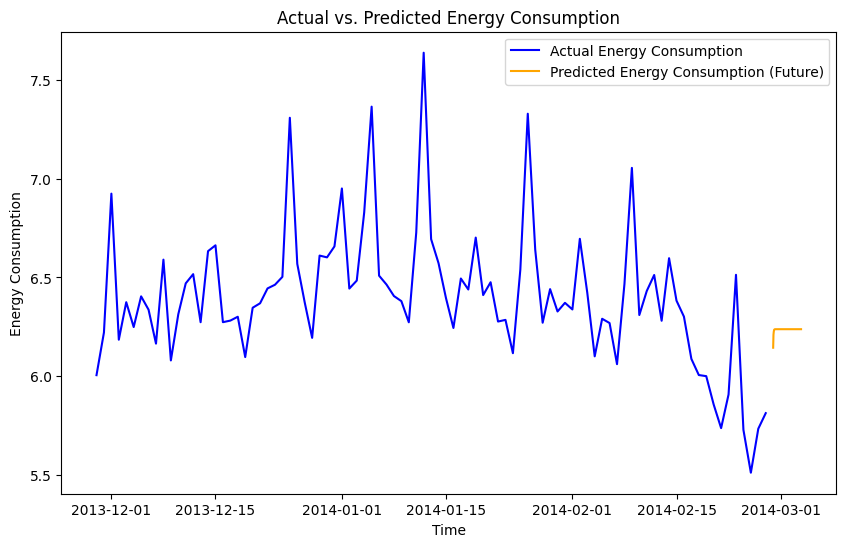

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Assuming hourly_with_temp_data is your DataFrame with energy consumption data
# Make sure the index is a datetime index
if 'DateTime' in daily_with_temp.columns:
    daily_with_temp['DateTime'] = pd.to_datetime(daily_with_temp['DateTime'])
    daily_with_temp.set_index('DateTime', inplace=True)
else:
    print("Error: 'DateTime' column not found in the DataFrame.")

# Split data into training and testing sets
train_size = int(len(daily_with_temp) * 0.8)
train_data, test_data = daily_with_temp[:train_size], daily_with_temp[train_size:]

# Convert 'average_energy_consumption' column to float type
train_data['average_energy_consumption'] = train_data['average_energy_consumption'].astype(float)
test_data['average_energy_consumption'] = test_data['average_energy_consumption'].astype(float)

# Train ARIMA model with temperature as exogenous variable
model = ARIMA(train_data['average_energy_consumption'], exog=train_data['temperature'], order=(2, 1, 2))
model_fit = model.fit()

# Make predictions starting from 2014-03
start_time = pd.Timestamp('2014-02-28')  # Start time for the predictions
future_index = pd.date_range(start=start_time, periods=len(test_data), freq='H', tz=test_data.index.tz)
future_exog = pd.Series([test_data['temperature'].iloc[-1]] * len(test_data), index=future_index)  # Repeat the last temperature value for the forecast period
future_predictions = model_fit.forecast(steps=len(test_data), exog=future_exog.values.reshape(-1, 1))

# Evaluate predictions
mse = mean_squared_error(test_data['average_energy_consumption'], future_predictions)
print('Mean Squared Error:', mse)

# Plot manually (adjust as needed)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(test_data.index, test_data['average_energy_consumption'], label='Actual Energy Consumption', color='blue')
ax1.plot(future_index, future_predictions, label='Predicted Energy Consumption (Future)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy Consumption')
ax1.set_title('Actual vs. Predicted Energy Consumption')
ax1.legend()
plt.show()


In [46]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Assuming daily_with_temp is your DataFrame with daily energy consumption data
# Make sure the index is a datetime index
if 'DateTime' in daily_with_temp.columns:
    daily_with_temp['DateTime'] = pd.to_datetime(daily_with_temp['DateTime'])
    daily_with_temp.set_index('DateTime', inplace=True)
else:
    print("Error: 'DateTime' column not found in the DataFrame.")

# Split data into training and testing sets
train_size = int(len(daily_with_temp) * 0.8)
train_data, test_data = daily_with_temp[:train_size], daily_with_temp[train_size:]

# Convert 'average_energy_consumption' column to float type
train_data['average_energy_consumption'] = train_data['average_energy_consumption'].astype(float)
test_data['average_energy_consumption'] = test_data['average_energy_consumption'].astype(float)

# Train ARIMA model with temperature as exogenous variable and seasonal component
model = ARIMA(train_data['average_energy_consumption'], exog=train_data['temperature'], seasonal_order=(1, 1, 1, 365))  # Assuming daily seasonality
model_fit = model.fit()

# Make predictions
forecast_steps = len(test_data)
future_index = pd.date_range(start=test_data.index[0], periods=forecast_steps, freq='D', tz=test_data.index.tz)
future_exog = pd.concat([pd.Series([test_data['temperature'].iloc[-1]] * forecast_steps)], axis=1)  # Repeat the last temperature value for the forecast period
future_predictions = model_fit.forecast(steps=forecast_steps, exog=future_exog)

# Evaluate predictions
mse = mean_squared_error(test_data['average_energy_consumption'], future_predictions)
print('Mean Squared Error:', mse)

# Plot manually (adjust as needed)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(test_data.index, test_data['average_energy_consumption'], label='Actual Energy Consumption', color='blue')
ax1.plot(future_index, future_predictions, label='Predicted Energy Consumption (Future)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy Consumption')
ax1.set_title('Actual vs. Predicted Energy Consumption with Seasonality and Exogenous Variable (Temperature)')
ax1.legend()
plt.show()


Error: 'DateTime' column not found in the DataFrame.


/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_42128/3331352410.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['average_energy_consumption'] = train_data['average_energy_consumption'].astype(float)
/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_42128/3331352410.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['average_energy_consumption'] = test_data['average_energy_consumption'].astype(float)
/Library/Frameworks/Python.framework/Versions/3.12/lib/pytho

KeyboardInterrupt: 